In [1]:
import pandas as pd

from pycausalmatch import R_MarketMatching as rmm

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
dir(rmm)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'best_matches',
 'calculate_distances',
 'create_market_vectors',
 'dw',
 'inference',
 'lagp',
 'log_plus',
 'mape_no_zeros',
 'read_data',
 'sapply',
 'stop_if']

In 1988, California passed the Tobacco Tax and Health Protection Act, which became known as Proposition 99.

“Its primary effect is to impose a 25-cent per pack state excise tax on the sale of tobacco cigarettes within California, with approximately equivalent excise taxes similarly imposed on the retail sale of other commercial tobacco products, such as cigars and chewing tobacco. Additional restrictions placed on the sale of tobacco include a ban on cigarette vending machines in public areas accessible by juveniles and a ban on the individual sale of single cigarettes. Revenue generated by the act was earmarked for various environmental and health care programs, and anti-tobacco advertisements.”

The impact of Prop 99 is a popular example used to illustrate the use of various causal inference techniques. Two sources that have analyzed the impact of Prop 99 are:

http://peerunreviewed.blogspot.com/2019/11/a-short-tutorial-on-robust-synthetic.html

and

https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html


In this notebook, I will compare the output from this package vs the output from the techniques in the sources above

###### Example 1

http://peerunreviewed.blogspot.com/2019/11/a-short-tutorial-on-robust-synthetic.html

In [3]:
# data from https://github.com/jehangiramjad/tslib
prop99 = pd.read_csv('./datasets/prop99.csv')
prop99.head(2)

,LocationAbbr,LocationDesc,Year,Datasource,TopicDesc,MeasureDesc,SubMeasureDesc,Data_Value,Data_Value_Unit,Data_Value_Type,GeoLocation,Source,TopicTypeId,TopicId,MeasureId,SubMeasureID,SubMeasureIdDisplayOrder
0,AL,Alabama,2014,OW,The Tax Burden on Tobacco,Cigarette Sales,Average Cost per pack,5.102,$,Dollars,"(32.84057112200048, -86.63186076199969)","Table 13- Orzechowski and Walker, Tax Burden o...",POL,450POL,450CGS,455CGS,1
1,AL,Alabama,2014,OW,The Tax Burden on Tobacco,Cigarette Sales,Cigarette Consumption (Pack Sales Per Capita),61.700,NaN,Pack,"(32.84057112200048, -86.63186076199969)","Table 11- Orzechowski and Walker, Tax Burden o...",POL,450POL,450CGS,453CGS,2


In [4]:
prop99['SubMeasureDesc'].unique()

array(['Average Cost per pack ',
       'Cigarette Consumption (Pack Sales Per Capita)',
       'Federal and State tax as a Percentage of Retail Price ',
       'Federal and State Tax per pack ', 'Gross Cigarette Tax Revenue ',
       'State Tax per pack '], dtype=object)

In [5]:
# filter for outcome variable of interest
cigs_prop99 = prop99[prop99['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']

In [6]:
cigs_prop99.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2295 entries, 1 to 13765
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   LocationAbbr              2295 non-null   object 
 1   LocationDesc              2295 non-null   object 
 2   Year                      2295 non-null   int64  
 3   Datasource                2295 non-null   object 
 4   TopicDesc                 2295 non-null   object 
 5   MeasureDesc               2295 non-null   object 
 6   SubMeasureDesc            2295 non-null   object 
 7   Data_Value                2295 non-null   float64
 8   Data_Value_Unit           0 non-null      object 
 9   Data_Value_Type           2295 non-null   object 
 10  GeoLocation               2295 non-null   object 
 11  Source                    2295 non-null   object 
 12  TopicTypeId               2295 non-null   object 
 13  TopicId                   2295 non-null   object 
 14  Measure

In [7]:
cigs_prop99['LocationDesc'].nunique()

51

In [8]:
# resolve the warning here
cigs_prop99['Year'] = pd.to_datetime(cigs_prop99['Year'], format='%Y')
cigs_prop99.head(2)

<ipython-input-8-8eef47803c3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cigs_prop99['Year'] = pd.to_datetime(cigs_prop99['Year'], format='%Y')


,LocationAbbr,LocationDesc,Year,Datasource,TopicDesc,MeasureDesc,SubMeasureDesc,Data_Value,Data_Value_Unit,Data_Value_Type,GeoLocation,Source,TopicTypeId,TopicId,MeasureId,SubMeasureID,SubMeasureIdDisplayOrder
1,AL,Alabama,2014-01-01,OW,The Tax Burden on Tobacco,Cigarette Sales,Cigarette Consumption (Pack Sales Per Capita),61.7,NaN,Pack,"(32.84057112200048, -86.63186076199969)","Table 11- Orzechowski and Walker, Tax Burden o...",POL,450POL,450CGS,453CGS,2
7,AK,Alaska,2014-01-01,OW,The Tax Burden on Tobacco,Cigarette Sales,Cigarette Consumption (Pack Sales Per Capita),37.2,NaN,Pack,"(64.84507995700051, -147.72205903599973)","Table 11- Orzechowski and Walker, Tax Burden o...",POL,450POL,450CGS,453CGS,2


In [9]:
cigs_prop99['Year'].min()

Timestamp('1970-01-01 00:00:00')

In [10]:
cigs_prop99['Year'].max()

Timestamp('2014-01-01 00:00:00')

In [11]:
# find the closest matches to CA's cigarette sales
best_matches_for_CA = rmm.best_matches(data=cigs_prop99, id_variable='LocationDesc', date_variable='Year',
                                          markets_to_be_matched = ['California'],
                                          matching_variable='Data_Value', parallel=False,
                                          warping_limit=1, dtw_emphasis=1,  matches=5,
                                          start_match_period=cigs_prop99['Year'].min(),
                                          end_match_period="1989-01-01"
                                         )

In [12]:
best_matches_for_CA.keys()

dict_keys(['best_matches', 'data', 'market_id', 'matching_metric', 'date_variable', 'suggested_test_control_splits'])

In [13]:
best_matches_for_CA["best_matches"]

,LocationDesc,BestControl,RelativeDistance,Correlation,Length,SUMTEST,SUMCNTL,RAWDIST,Correlation_of_logs,matching_start_date,matching_end_date,rank
26,California,Montana,0.037286,0.946129,20.0,2290.4,2269.6,85.4,0.946129,1970-01-01,1989-01-01,0
12,California,Idaho,0.050733,0.939087,20.0,2290.4,2209.1,116.2,0.939087,1970-01-01,1989-01-01,1
2,California,Arizona,0.069420,0.879199,20.0,2290.4,2318.7,159.0,0.879199,1970-01-01,1989-01-01,2
15,California,Iowa,0.086186,0.751351,20.0,2290.4,2284.4,197.4,0.751351,1970-01-01,1989-01-01,3
48,California,West Virginia,0.086229,0.796903,20.0,2290.4,2352.5,197.5,0.796903,1970-01-01,1989-01-01,4
21,California,Massachusetts,0.099546,0.825667,20.0,2290.4,2374.4,228.0,0.825667,1970-01-01,1989-01-01,5


In [14]:
impact_on_CA = rmm.inference(matched_markets = best_matches_for_CA,
                                     test_market = "California",
                                     end_post_period = "2015-01-01"
                                     )

------------- Inputs -------------
Test Market: California
Control Market 0: Arizona
Control Market 1: Idaho
Control Market 2: Iowa
Control Market 3: Massachusetts
Control Market 4: Montana
Control Market 5: West Virginia
prior_level_sd : 0.01
No seasonality component (controlled for by the matched markets) 
Posterior Intervals Tail Area: 95.0


/Users/rjuma001/anaconda3/envs/ci/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/rjuma001/anaconda3/envs/ci/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


------------- Model Stats -------------
Matching (pre) Period MAPE: 


In [15]:
impact_on_CA

{'causal_impact_object': <causalimpact.main.CausalImpact at 0x7ff2f349c820>,
 'summary_data':                     average   cumulative
 actual            42.576000  1064.400000
 predicted         37.608665   940.216630
 predicted_lower   33.569258   839.231458
 predicted_upper   41.849610  1046.240243
 abs_effect         4.967335   124.183370
 abs_effect_lower   0.726390    18.159757
 abs_effect_upper   9.006742   225.168542
 rel_effect         0.132080     0.132080
 rel_effect_lower   0.019314     0.019314
 rel_effect_upper   0.239486     0.239486,
 'all_output_plots': <bound method Plot.plot of <causalimpact.main.CausalImpact object at 0x7ff2f349c820>>}

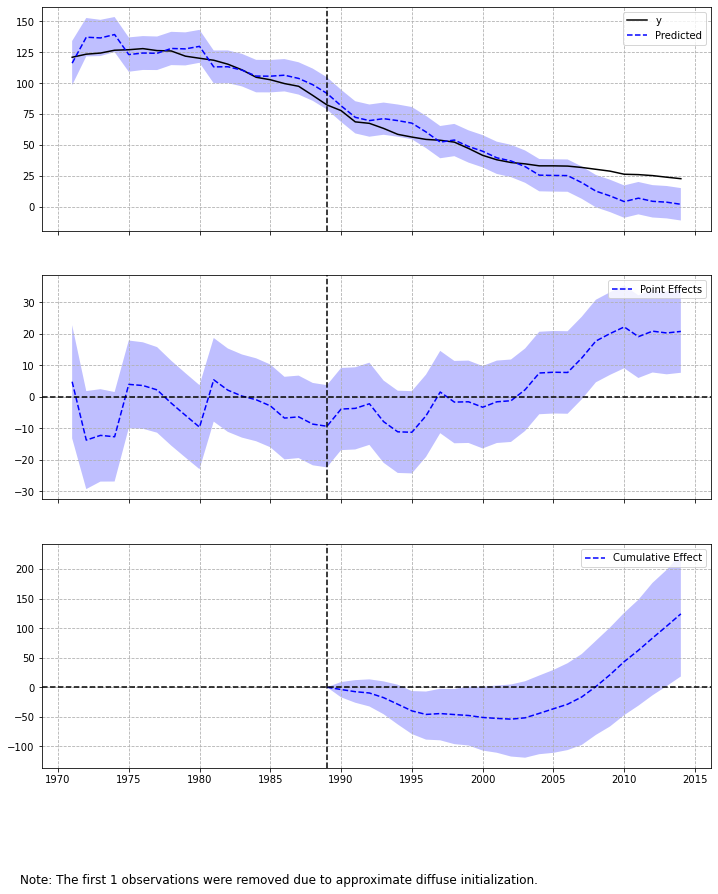

In [28]:
impact_on_CA['all_output_plots'](figsize=(12, 14))

The above plot shows the opposite impact than what is widely accepted, and shown in the blog as well!

I will dig deeper here, but the next example excudes some states that also enacted similar Tobacco control measures

###### Example 2

https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html

In [17]:
# data from https://github.com/matheusfacure/python-causality-handbook
smoke_df = pd.read_csv('./datasets/smoking.csv')
smoke_df.head(2)

,state,year,cigsale,lnincome,beer,age15to24,retprice,california,after_treatment
0,1,1970,89.800003,NaN,NaN,0.178862,39.599998,False,False
1,1,1971,95.400002,NaN,NaN,0.179928,42.700001,False,False


In [18]:
smoke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   state            1209 non-null   int64  
 1   year             1209 non-null   int64  
 2   cigsale          1209 non-null   float64
 3   lnincome         1014 non-null   float64
 4   beer             546 non-null    float64
 5   age15to24        819 non-null    float64
 6   retprice         1209 non-null   float64
 7   california       1209 non-null   bool   
 8   after_treatment  1209 non-null   bool   
dtypes: bool(2), float64(5), int64(2)
memory usage: 68.6 KB


In [19]:
smoke_df['state'].nunique()

39

The values in the column `state` are numeric (California has the value 3) - I will try and find a dataset that has the actual names of the states

The outcome variable of interest `cigsale` is per-capita sales of cigarettes in packs

In [20]:
smoke_df['year'] = pd.to_datetime(smoke_df['year'], format='%Y')
smoke_df.head(2)

,state,year,cigsale,lnincome,beer,age15to24,retprice,california,after_treatment
0,1,1970-01-01,89.800003,NaN,NaN,0.178862,39.599998,False,False
1,1,1971-01-01,95.400002,NaN,NaN,0.179928,42.700001,False,False


In [21]:
smoke_df['year'].min()

Timestamp('1970-01-01 00:00:00')

In [22]:
smoke_df['year'].max()

Timestamp('2000-01-01 00:00:00')

In [23]:
best_match_for_CA = rmm.best_matches(data=smoke_df, id_variable='state', date_variable='year',
                                  markets_to_be_matched = [3],
                                  matching_variable='cigsale', parallel=False,
                                  warping_limit=1, dtw_emphasis=1,  matches=5,
                                  start_match_period=smoke_df['year'].min(),
                                  end_match_period="1989-01-01"
                                 )

In [24]:
best_match_for_CA["best_matches"]

,state,BestControl,RelativeDistance,Correlation,Length,SUMTEST,SUMCNTL,RAWDIST,Correlation_of_logs,matching_start_date,matching_end_date,rank
18,3,19,0.036544,0.946129,20.0,2290.400002,2269.599983,83.699989,0.946129,1970-01-01,1989-01-01,0
7,3,8,0.046629,0.939087,20.0,2290.400002,2209.099998,106.799988,0.939087,1970-01-01,1989-01-01,1
10,3,11,0.082518,0.751351,20.0,2290.400002,2284.399979,188.999962,0.751351,1970-01-01,1989-01-01,2
36,3,37,0.088063,0.796903,20.0,2290.400002,2352.499992,201.699982,0.796903,1970-01-01,1989-01-01,3
24,3,25,0.101118,0.683826,20.0,2290.400002,2195.700005,231.600014,0.683826,1970-01-01,1989-01-01,4
3,3,4,0.106444,0.949868,20.0,2290.400002,2461.600006,243.800003,0.949868,1970-01-01,1989-01-01,5


In [25]:
inference_for_ex_2 = rmm.inference(matched_markets = best_match_for_CA,
                                     test_market = 3,
                                     end_post_period = "2001-01-01"
                                     )

ERROR: inference() can only analyze one test market at a time.                 Call the function separately for each test market
------------- Inputs -------------
Test Market: 3
Control Market 0: 4
Control Market 1: 8
Control Market 2: 11
Control Market 3: 19
Control Market 4: 25
Control Market 5: 37
prior_level_sd : 0.01
No seasonality component (controlled for by the matched markets) 
Posterior Intervals Tail Area: 95.0


/Users/rjuma001/anaconda3/envs/ci/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/rjuma001/anaconda3/envs/ci/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


------------- Model Stats -------------
Matching (pre) Period MAPE: 


In [26]:
inference_for_ex_2

{'causal_impact_object': <causalimpact.main.CausalImpact at 0x7ff2f4f8f5e0>,
 'summary_data':                     average  cumulative
 actual            58.345454  641.799999
 predicted         78.906956  867.976512
 predicted_lower   75.600857  831.609432
 predicted_upper   82.344614  905.790759
 abs_effect       -20.561501 -226.176512
 abs_effect_lower -23.999160 -263.990760
 abs_effect_upper -17.255403 -189.809433
 rel_effect        -0.260579   -0.260579
 rel_effect_lower  -0.304145   -0.304145
 rel_effect_upper  -0.218680   -0.218680,
 'all_output_plots': <bound method Plot.plot of <causalimpact.main.CausalImpact object at 0x7ff2f4f8f5e0>>}

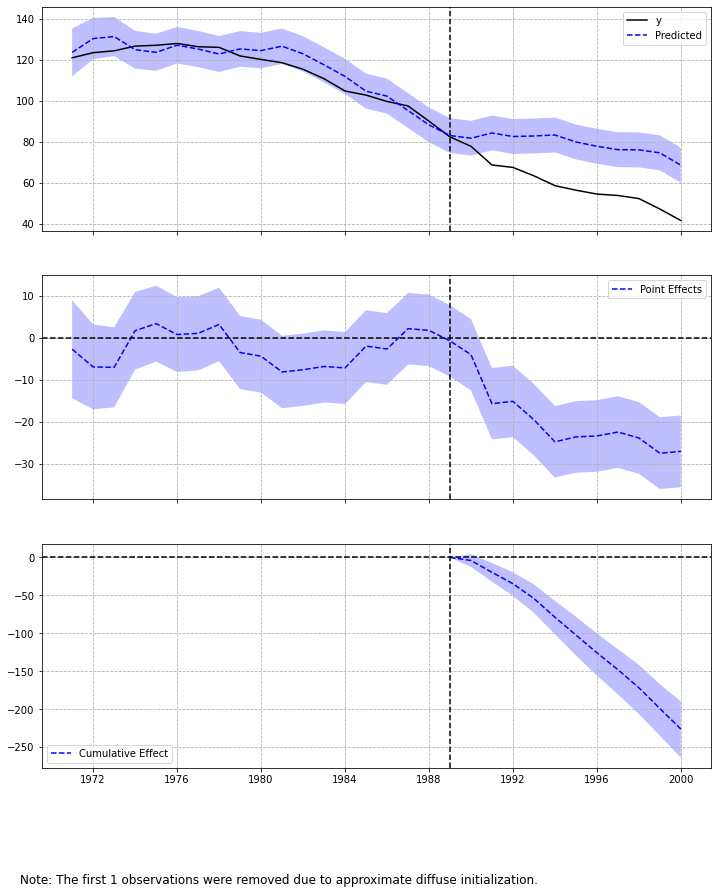

In [27]:
inference_for_ex_2['all_output_plots'](figsize=(12, 14))

The output for the second example matches the output in the book